# Assignment: Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).
Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

С небольшой вероятностью вы можете натолкнуться на случай, когда полученное вами качество в каком-то из пунктов не попадет в диапазон, заданный для правильных ответов - в этом случае попробуйте перезапустить ячейку с cross_val_score несколько раз и выбрать наиболее «типичное» значение. Если это не помогает, то где-то была допущена ошибка.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs, но будьте осторожны: в одной из старых версий sklearn была ошибка, которая приводила к неверному результату работы cross_val_score при задании n_jobs отличным от 1. Сейчас такой проблемы возникнуть не должно, но проверить, что все в порядке, не будет лишним.

In [30]:
%matplotlib inline
from sklearn import datasets, cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn

In [3]:
dataset = datasets.load_digits()
X = dataset['data']
y = dataset['target']
print dataset['DESCR']

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### Шаг 1
Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. Эта величина и будет ответом в пункте 1.

In [10]:
clf = DecisionTreeClassifier()
scores = cross_validation.cross_val_score(clf, X, y, cv = 10)
scores.mean()

0.83745569124142649

### Шаг 2

Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.
Качество классификации новой модели - ответ в пункте 2. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [12]:
clf = BaggingClassifier(n_estimators = 100)
scores = cross_validation.cross_val_score(clf, X, y, cv = 10)
scores.mean()

0.92378232539004013

### Шаг 3
Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Качество работы получившегося классификатора - ответ в пункте 3. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [15]:
d = X.shape[1]
number_of_features = int(d ** 0.5)
number_of_features

8

In [16]:
clf = BaggingClassifier(n_estimators = 100, max_features = number_of_features)
scores = cross_validation.cross_val_score(clf, X, y, cv = 10)
scores.mean()

0.93925292468934418

### Шаг 4
Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$ признаков. Качество полученного классификатора на контрольной выборке и будет ответом в пункте 4.

In [17]:
clf = BaggingClassifier(DecisionTreeClassifier(max_features = number_of_features), n_estimators = 100)
scores = cross_validation.cross_val_score(clf, X, y, cv = 10)
scores.mean()

0.95054923185011297

### Шаг 5

Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера (это будет ответ в п.5)

  1. ~~Случайный лес сильно переобучается с ростом количества деревьев~~
  2. При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев
  3. С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.
  4. При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.
  5. ~~При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.~~
  6. ~~При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.~~
  7. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

In [20]:
clf = RandomForestClassifier(n_estimators = 100, max_features = number_of_features)
scores = cross_validation.cross_val_score(clf, X, y, cv = 10)
scores.mean()

0.94767591388439654

#### Зависимость от количества деревьев

In [49]:
number_of_estimators = np.arange(5, 150, 5)
scores_estimators = []
for n in number_of_estimators:
    print n,
    clf = RandomForestClassifier(n_estimators = n, max_features = number_of_features)
    scores_estimators.append(cross_validation.cross_val_score(clf, X, y, cv = 10).mean())

5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145


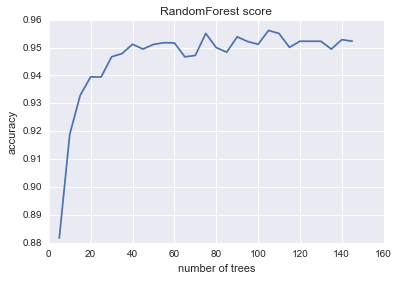

In [50]:
plt.plot(number_of_estimators, scores_estimators)
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.title('RandomForest score')

#### Зависимость от количества признаков

In [41]:
number_of_features_list = np.arange(5, d, 5)
scores_features = []
for n in number_of_features_list:
    print n,
    clf = RandomForestClassifier(n_estimators = 100, max_features = n)
    scores_features.append(cross_validation.cross_val_score(clf, X, y, cv = 10).mean())

5 10 15 20 25 30 35 40 45 50 55 60


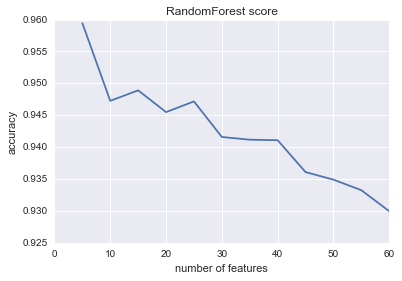

In [48]:
plt.plot(number_of_features_list, scores_features)
plt.xlabel('number of features')
plt.ylabel('accuracy')
plt.title('RandomForest score')

#### Зависимость от глубины деревьев

In [44]:
depths = np.arange(1, 30, 1)
scores_depth = []
for n in depths:
    print n,
    clf = RandomForestClassifier(n_estimators = 100, max_features = number_of_features, max_depth = n)
    scores_depth.append(cross_validation.cross_val_score(clf, X, y, cv = 10).mean())

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29


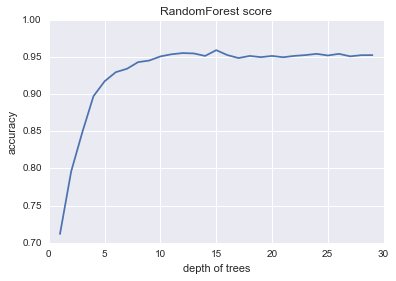

In [47]:
plt.plot(depths, scores_depth)
plt.xlabel('depth of trees')
plt.ylabel('accuracy')
plt.title('RandomForest score')